In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [33]:
batch_size = 100

In [5]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [7]:
X_train.shape

(60000, 28, 28)

In [29]:
X_train = (X_train.reshape(-1, (28*28)).astype('float32') - 127.5) / 127.5

In [31]:
X_train

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1024).batch(batch_size)

In [37]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)>

In [15]:
# X_train

In [13]:
# X_train.reshape(-1, (28*28))

In [25]:
# 255/2

In [65]:
mnist_dim = 28 * 28
n_g = 256
z_dim = 100
lr = 0.0002
n_epochs = 1

In [41]:
# Generator
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(n_g, input_dim=z_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(n_g * 2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(n_g * 4))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(mnist_dim, activation='tanh'))
    return model   

In [53]:
# Discriminator
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(n_g * 4, input_dim=mnist_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(n_g * 2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(n_g))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [55]:
# Creat Model
G = build_generator()

D = build_discriminator()

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
D.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr))

In [59]:
D.trainable = False

In [61]:
z = layers.Input(shape=(z_dim,))
img = G(z)
valid = D(img)
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr))

In [63]:
# train
loss_D_hist = []
loss_G_hist = []

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/1: D Loss: 4.5006, G Loss: 4.5089
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


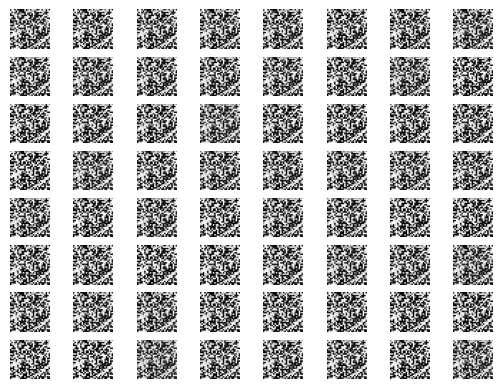

In [69]:
for epoch in range(n_epochs):
    loss_D_avg=[]
    loss_G_avg=[]
    for x_batch in dataset:
        batch_size = x_batch.shape[0]
        y_real = np.ones((batch_size,1))
        y_fake = np.zeros((batch_size,1))

        z = np.random.normal(0, 1, (batch_size, z_dim))
        x_fake = G.predict(z, verbose=0)

        D_loss_real = D.train_on_batch(x_batch, y_real)
        D_loss_fake = D.train_on_batch(x_fake, y_fake)
        D_loss = 0.5 * (D_loss_real + D_loss_fake)
        loss_D_avg.append(D_loss)

        G_loss = combined.train_on_batch(z, y_real)
        loss_G_avg.append(G_loss)

    loss_D_hist.append(np.mean(loss_D_avg))
    loss_G_hist.append(np.mean(loss_G_avg))

    print(f'Epoch {epoch + 1}/{n_epochs}: D Loss: {np.mean(loss_D_avg):.4f}, G Loss: {np.mean(loss_G_avg):.4f}')
    
    z = np.random.normal(0, 1, (64, z_dim))
    generated_imgs = G.predict(z)
    generated_imgs = 0.5 * generated_imgs + 0.5
    fig, axs = plt.subplots(8, 8)
    cnt = 0
    for i in range(8):
        for j in range(8):
            axs[cnt // 8, cnt % 8].imshow(generated_imgs[cnt].reshape(28, 28), cmap='gray')
            axs[cnt // 8, cnt % 8].axis('off')
            cnt += 1
    plt.show()